In [1]:
from splender.image import SplenderImage
import jax.random as random
from jax import vmap, value_and_grad, grad, jit
from interpax import Interpolator1D
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from minimum_spanning_tree_inverse_spline_render import get_splines_from_frame

import matplotlib.pyplot as plt

import jax.tree_util as jtu

import optax


In [2]:
dat = np.loadtxt('mnist_train.csv', delimiter=',')

In [3]:
def fit_spline(knots):
    x, y = knots[..., 0], knots[..., 1]
    
    s = jnp.linspace(0, 1, len(x))
    x_spline = Interpolator1D(s, x, method="cubic2")
    y_spline = Interpolator1D(s, y, method="cubic2")
    return x_spline, y_spline

def get_uniform_points(x_spline, y_spline, n_points_per_spline = 8):
    eps = 1e-6
    # Compute arc length
    dx_ds = vmap(partial(x_spline, dx=1))
    dy_ds = vmap(partial(y_spline, dx=1))
    s_fine = jnp.linspace(0, 1, n_points_per_spline)
    ds_vals = jnp.sqrt(dx_ds(s_fine)**2 + dy_ds(s_fine)**2 + eps)
    delta_s = s_fine[1] - s_fine[0]
    cumulative_length = jnp.concatenate([
        jnp.array([0.0]),
        jnp.cumsum(0.5 * (ds_vals[1:] + ds_vals[:-1]) * delta_s)
    ])
    s_uniform = jnp.interp(jnp.linspace(0, cumulative_length[-1], n_points_per_spline), cumulative_length, s_fine)
    return s_uniform, cumulative_length[-1]

def downsample_points(coords):
    x_spline, y_spline = fit_spline(coords)
    s_uniform, length = get_uniform_points(x_spline, y_spline, n_points_per_spline=8)
    x = x_spline(s_uniform)
    y = y_spline(s_uniform)
    return jnp.stack([x, y], axis=-1)

36
(8, 2)


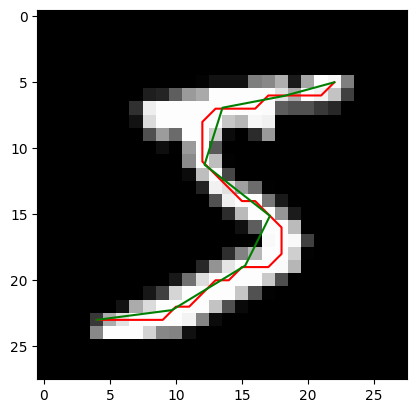

40
(8, 2)


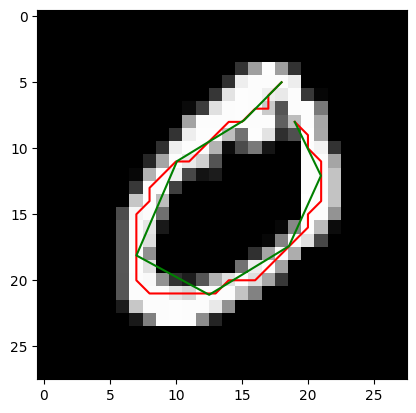

31
(8, 2)


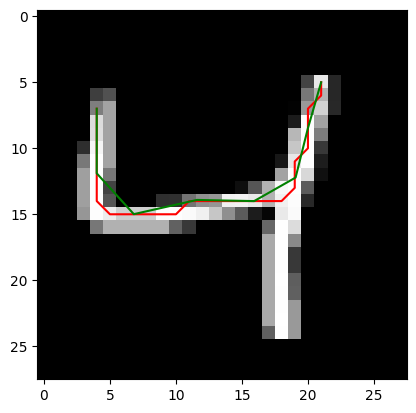

18
(8, 2)


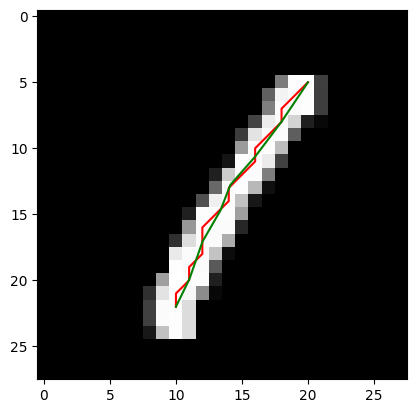

25
(8, 2)


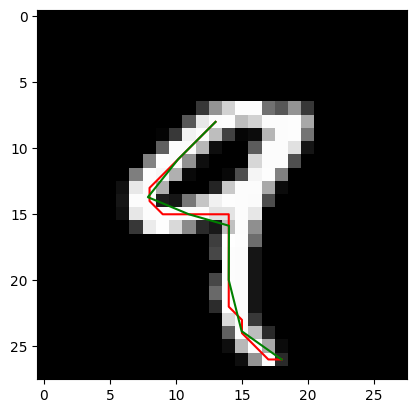

31
(8, 2)


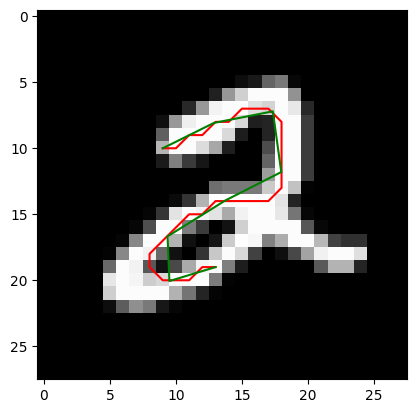

19
(8, 2)


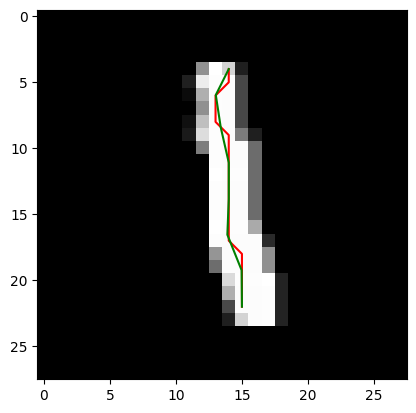

35
(8, 2)


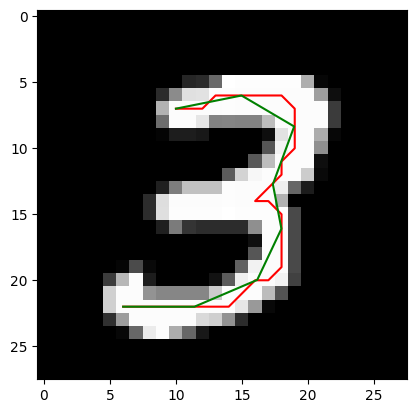

18
(8, 2)


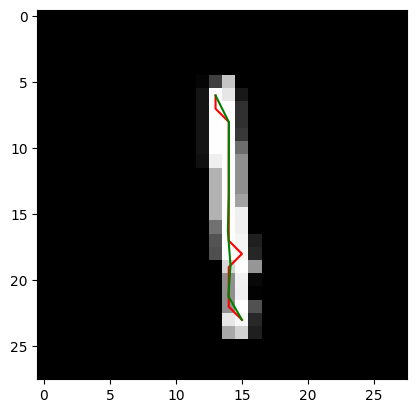

24
(8, 2)


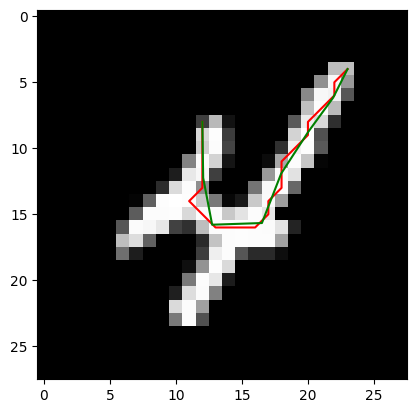

24
(8, 2)


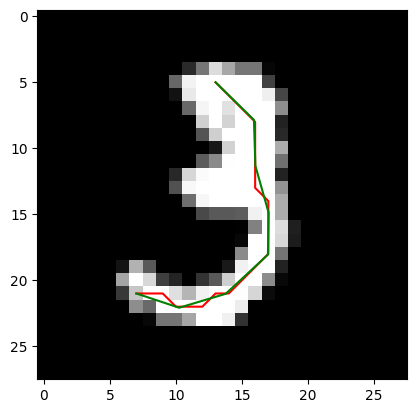

24
(8, 2)


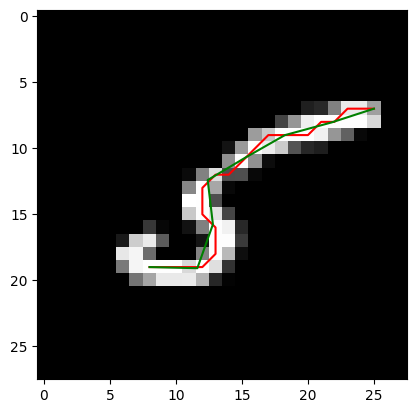

In [4]:
n_images = 12
images = []
init_splines = []
for i in range(n_images):
    img = dat[i, 1:].reshape(28, 28)
    img = img / 255.0
    images.append(img)
    path = get_splines_from_frame(img, 0.1)[0][:, ::-1]
    print(len(path))
    init_spline = np.array(path).astype(np.float32)
    init_spline = downsample_points(init_spline)
    init_splines.append(init_spline[None])
    print(init_spline.shape)
    plt.imshow(img, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], 'r-')
    plt.plot(init_spline[:, 0], init_spline[:, 1], 'g-')
    plt.show()

In [5]:
images = jnp.array(images)

In [6]:
init_splines = jnp.array(init_splines) / 28

In [7]:
# model = SplenderImage(random.PRNGKey(0), init_splines, res = 28)
model = SplenderImage(key = random.PRNGKey(0), init_knots=init_splines, res=28, global_scale = 0.3)

In [8]:
# model = model.init(random.PRNGKey(0), init_knots=init_splines, res=28)

In [9]:
model.res

28

In [10]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [11]:
ims, lengths, curvatures = model()

In [12]:
ims

Array([[[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       ...,

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5

In [13]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [14]:
model

SplenderImage(key=Array([0, 0], dtype=uint32), init_knots=Array([[[[0.7857143 , 0.17857143],
         [0.65102094, 0.21523765],
         [0.48311573, 0.24745078],
         [0.43446246, 0.4014924 ],
         [0.61147964, 0.5399473 ],
         [0.5445244 , 0.6745746 ],
         [0.34601074, 0.79507387],
         [0.14285715, 0.8214286 ]]],


       [[[0.6428572 , 0.17857143],
         [0.5413259 , 0.28139448],
         [0.36001077, 0.39203376],
         [0.25022063, 0.64712614],
         [0.44705305, 0.7536151 ],
         [0.66284204, 0.62194866],
         [0.74946797, 0.43117237],
         [0.67857146, 0.2857143 ]]],


       [[[0.75000006, 0.17857143],
         [0.7141937 , 0.30295667],
         [0.68084264, 0.43639126],
         [0.5686655 , 0.50008315],
         [0.4139364 , 0.49689198],
         [0.2431933 , 0.53536004],
         [0.14274769, 0.42486623],
         [0.14285715, 0.25000003]]],


       [[[0.35714287, 0.7857143 ],
         [0.39378458, 0.7104562 ],
         [0.4291762 

In [15]:
@jit
def loss(model, images):
    """
    Loss per image, summed over all images
    """
    recon, lengths, curvatures = model()
    assert recon.ndim == 3
    assert recon.shape == images.shape
    recon_loss = jnp.mean((images - recon) ** 2, axis=(-1, -2))
    min_scale_knots = jax.nn.sigmoid((model.loc_params + model.knot_params)[..., 2]).min(axis = -1)
    # jax.debug.print("min_scale_knots: {min_scale_knots}", min_scale_knots=min_scale_knots)
    scale_multiplier_reg = 1e-3 * ((min_scale_knots - 1.0)**2).mean(axis=-1)
    # curvature_reg = 1e-2 * curvatures.mean(axis=-1)
    curvature_reg = 1e-3 * curvatures.mean(axis=-1)
    length_reg = 1e-3 * lengths.mean(axis=-1)
    return (recon_loss + scale_multiplier_reg + curvature_reg + length_reg).sum()

def make_step(model, images, opt_state):
    loss_value, grads = value_and_grad(loss)(model, images)
    # grads = grad(loss)(model, images)
    # jax.debug.print("loss: {loss_value}", loss_value=loss_value)
    # jax.debug.print("grads: {grads}", grads=grads)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state, loss_value

In [16]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [18]:
optim = optax.adam(1e-2)
losses = []
opt_state = optim.init(model)
for step in range(1000):
    model, opt_state, loss_value = make_step(model, images, opt_state)
    losses.append(loss_value)

In [19]:
# optim = optax.adam(1e-4)
# opt_state = optim.init(model)
# for step in range(1):
#     model, opt_state, loss_value = make_step(model, images, opt_state)
#     # model_s, opt_state, loss_value = make_step(model, images, opt_state, filter_splines)
#     # losses.append(loss_value)

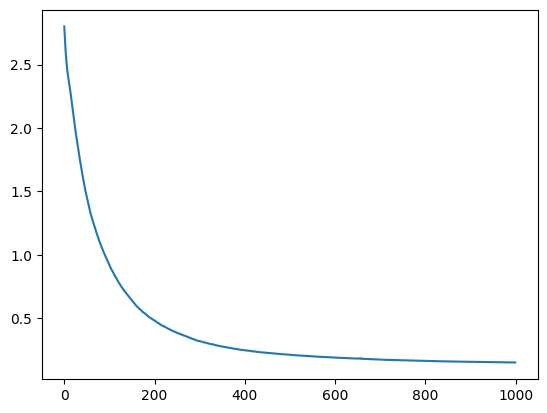

In [20]:
plt.plot(losses)
# plt.ylim(0.0665, 0.0668)

In [21]:
ims, lengths, curvatures = model()

In [22]:
print("model.loc_params", model.loc_params)
print("model.knot_params", model.knot_params)
print("model.global_scale", model.global_scale)
print("model.brush_profile", model.brush_profile)
print("model.kernel", model.kernel)
print("model.opacity", model.opacity)

model.loc_params [[[[-1.5599154e-01  4.6430811e-02  5.0000000e+00]]]


 [[[ 4.5474082e-02 -2.8930855e-01  5.0000000e+00]]]


 [[[-1.3477552e-01 -1.7225116e-02  5.0000000e+00]]]


 [[[ 4.7791824e-03  2.0346600e-01  5.0000000e+00]]]


 [[[ 6.8077497e-02  1.5503779e-01  5.0000000e+00]]]


 [[[-6.6437542e-02  1.6048270e-01  5.0000000e+00]]]


 [[[-7.9358742e-04 -1.6103376e-01  5.0000000e+00]]]


 [[[-2.1721014e-01  2.2340044e-01  5.0000000e+00]]]


 [[[-2.0014234e-02  1.2247817e-01  5.0000000e+00]]]


 [[[ 2.1762922e-01 -3.1065598e-01  5.0000000e+00]]]


 [[[-3.0118865e-01  3.0855680e-01  5.0000000e+00]]]


 [[[ 9.6889839e-02 -1.0197861e-01  5.0000000e+00]]]]
model.knot_params [[[[ 1.5145853  -1.4578063   0.        ]
   [-0.7388207  -0.96445465  0.        ]
   [ 0.00250947 -1.1612432   0.        ]
   [-0.17885347 -0.48529857  0.        ]
   [ 0.78795505  0.40015912  0.        ]
   [ 0.35905552  0.7794233   0.        ]
   [-0.22035931  1.2018188   0.        ]
   [-1.5260718   1.6874015   0.

In [23]:
ims.shape

(12, 28, 28)

In [24]:
xy_splines = [model.fit_spline(model.loc_params[i, 0] + model.knot_params[i, 0])[:2] for i in range(12)]

In [25]:
xy_splines[0]

(Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ),
 Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ))

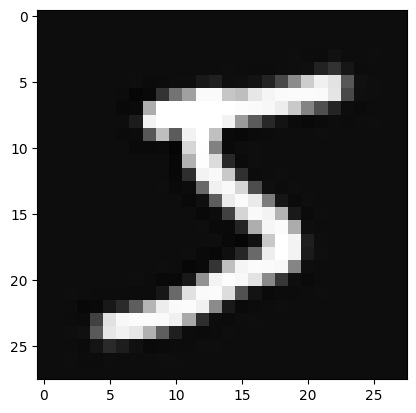

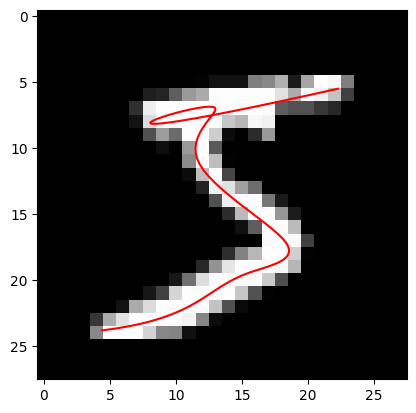

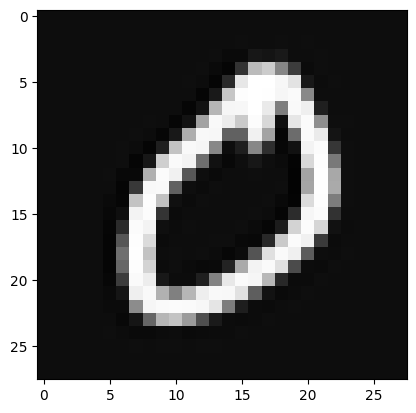

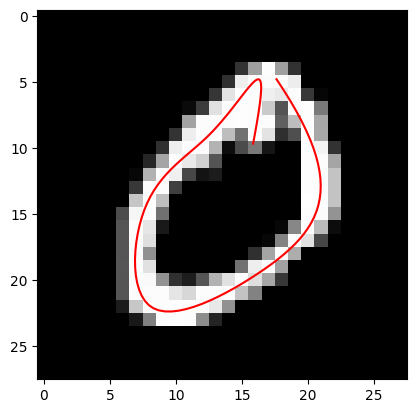

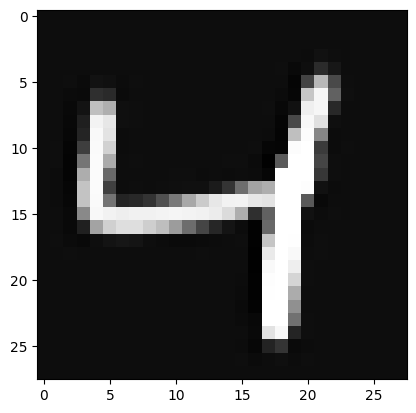

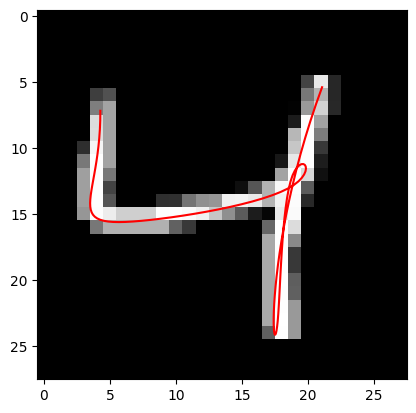

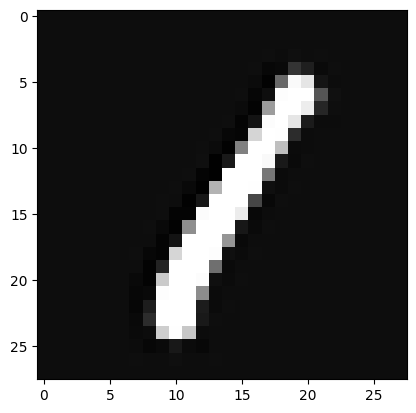

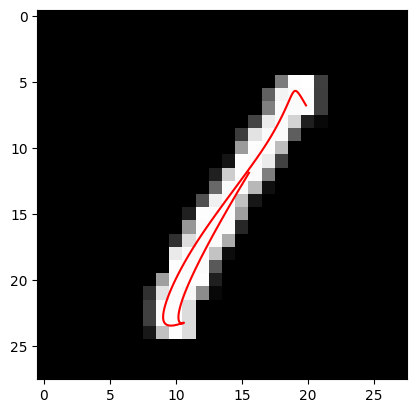

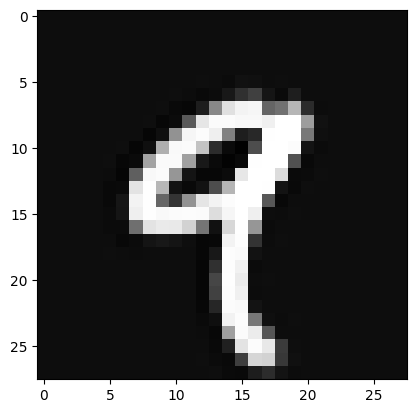

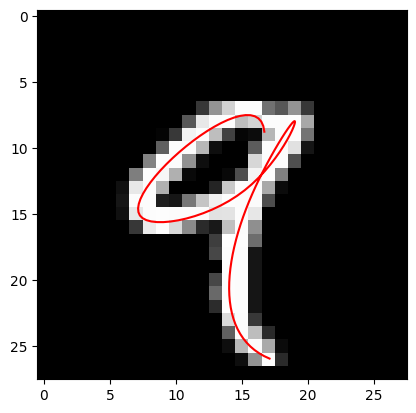

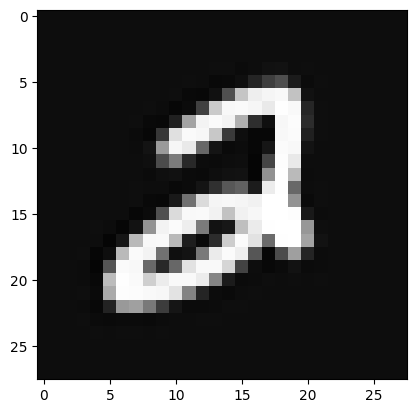

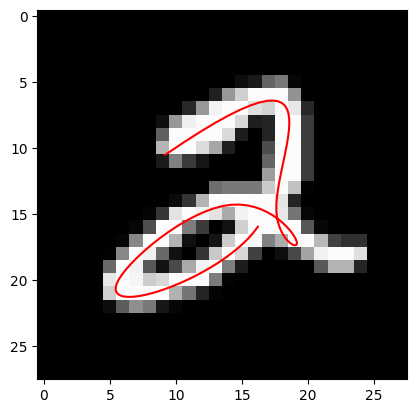

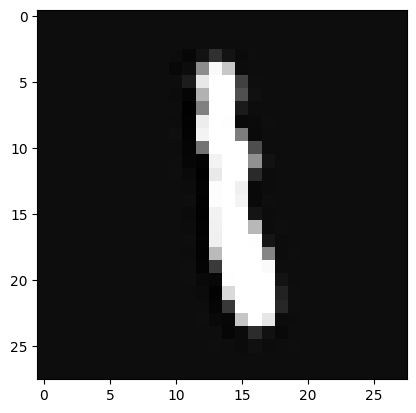

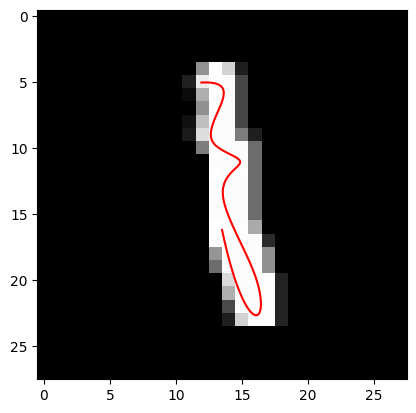

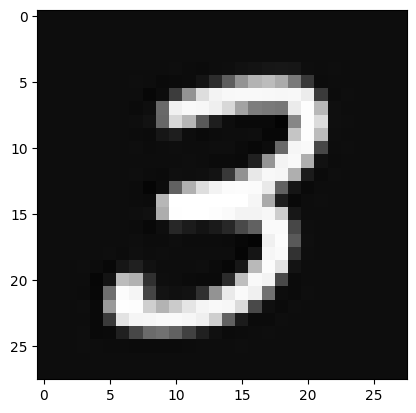

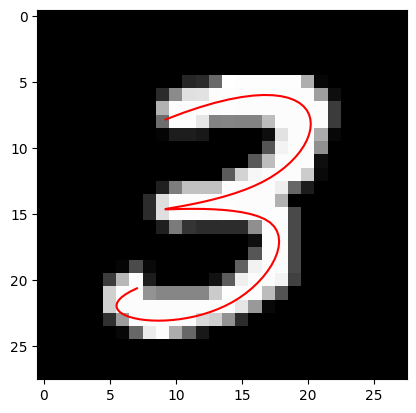

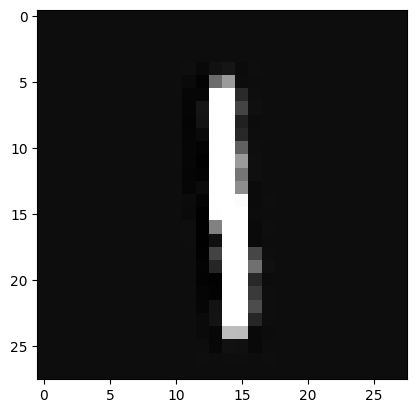

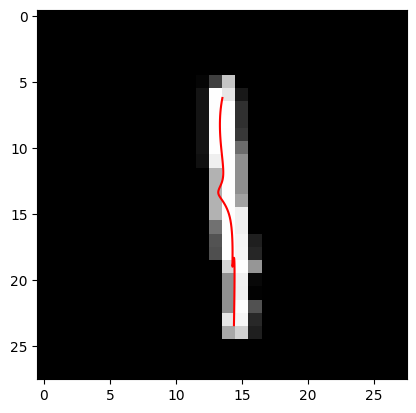

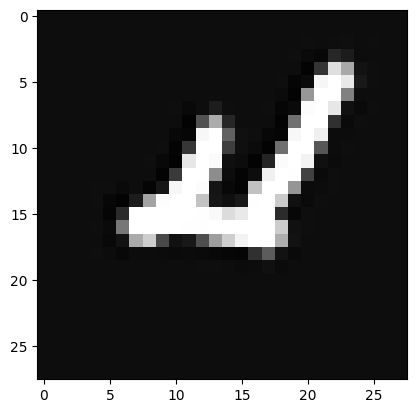

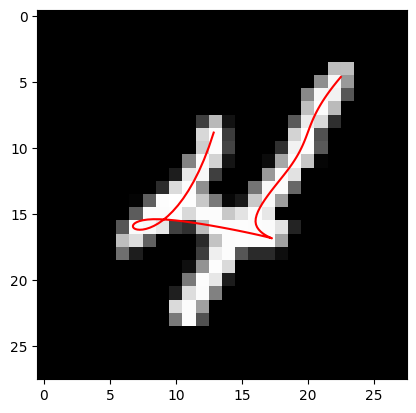

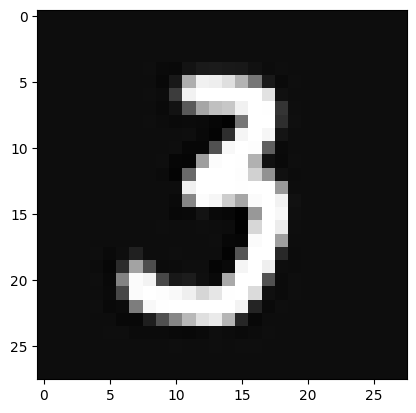

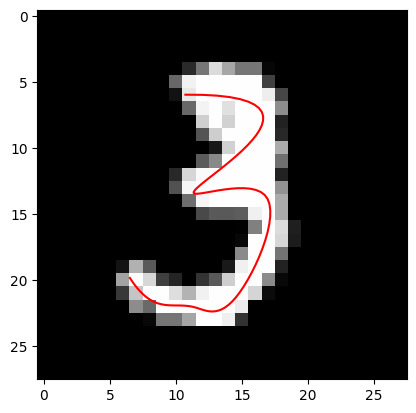

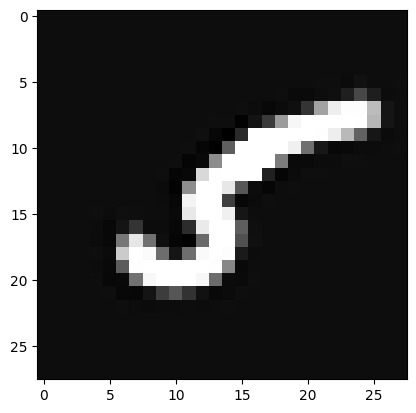

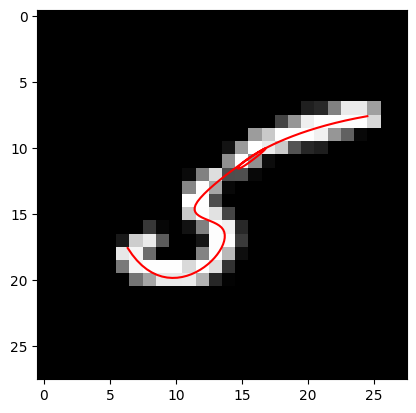

In [26]:
for i in range(n_images):
    plt.imshow(ims[i], cmap='gray', vmin=0, vmax=1)
    plt.show()
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=1)
    plt.plot(model.res * xy_splines[i][0](jnp.linspace(0, 1, 100)), model.res * xy_splines[i][1](jnp.linspace(0, 1, 100)), c='r')
    plt.show()